In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pulp import LpProblem, LpMinimize, LpVariable, lpSum, LpBinary
import folium

In [ ]:
# 데이터 로드
d_data = pd.read_csv(r'C:\Users\82102\OneDrive\첨부 파일\경희대학교\강의\3-1\물류관리\물류관리_텀프\processed_data\p_median_d_variable.csv')  # 거리 데이터
h_data = pd.read_csv(r'C:\Users\82102\OneDrive\첨부 파일\경희대학교\강의\3-1\물류관리\물류관리_텀프\processed_data\real_p_median_h_variable.csv')  # 수요 데이터
facility_data = pd.read_csv(r'C:\Users\82102\OneDrive\첨부 파일\경희대학교\강의\3-1\물류관리\물류관리_텀프\processed_data\영통구 공공시설_레알최종본.csv') # 공공시설 데이터

In [ ]:
# 거리 및 수요 데이터 추출
h_values = h_data['val'].values  # 수요량
num_candidates = len(d_data.columns) - 2  # 후보지 개수 계산
d_matrix = d_data.iloc[:, 1:num_candidates + 1].values  # 거리 행렬 추출

p = 1, Objective Value = 399940.2214587198, Selected Facilities = [20]
p = 2, Objective Value = 261461.63769397035, Selected Facilities = [20, 27]
p = 3, Objective Value = 214202.60711546522, Selected Facilities = [2, 3, 27]
p = 4, Objective Value = 175966.58397921175, Selected Facilities = [2, 3, 15, 25]
p = 5, Objective Value = 158042.09665922675, Selected Facilities = [2, 3, 8, 15, 25]
p = 6, Objective Value = 144783.89235917805, Selected Facilities = [1, 2, 3, 8, 15, 25]
p = 7, Objective Value = 133175.01564861363, Selected Facilities = [1, 2, 3, 6, 8, 10, 11]
p = 8, Objective Value = 124462.13493547188, Selected Facilities = [1, 2, 3, 6, 8, 10, 21, 27]
p = 9, Objective Value = 115948.04387464421, Selected Facilities = [1, 2, 3, 6, 8, 10, 11, 20, 27]
p = 10, Objective Value = 107876.26577527418, Selected Facilities = [1, 2, 3, 6, 8, 10, 11, 14, 20, 27]


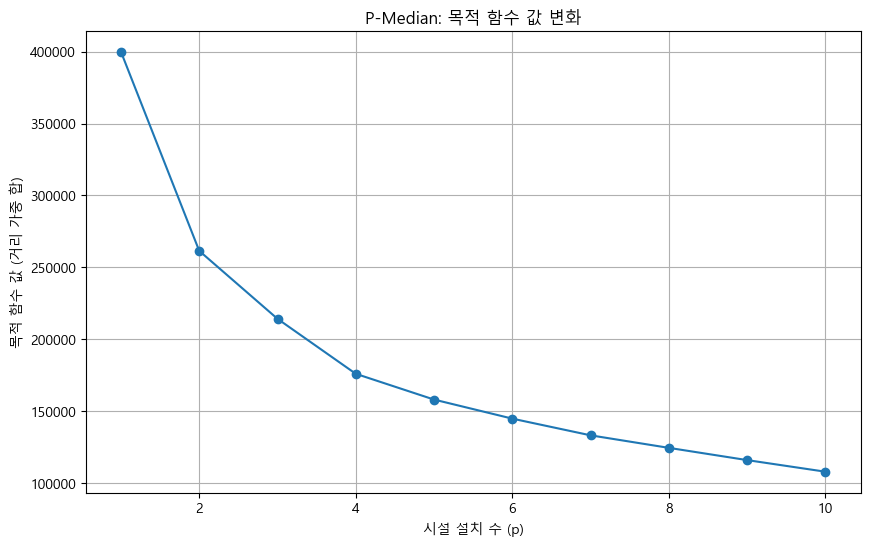

In [ ]:
# 최적화 함수 정의
def solve_p_median(d_matrix, h_values, num_candidates, p):
    """
    P-Median 문제를 풀기 위한 최적화 함수.
    :param d_matrix: 거리 행렬 (numpy array 또는 2D 리스트)
    :param h_values: 수요량 리스트 (1D 리스트)
    :param num_candidates: 후보지 개수 (int)
    :param p: 설치할 시설 개수 (int)
    :return: 최적화된 목적 함수 값과 선택된 시설 리스트
    """
    # 문제 정의
    prob = LpProblem(f"P-Median_p{p}", LpMinimize)
    
    # 결정 변수 정의
    x = LpVariable.dicts("x", range(num_candidates), cat=LpBinary)  # 시설 설치 여부
    y = LpVariable.dicts("y", [(i, j) for i in range(len(h_values)) for j in range(num_candidates)], cat=LpBinary)  # 수요-시설 할당
    
    # 목적 함수 정의
    prob += lpSum(h_values[i] * d_matrix[i, j] * y[(i, j)] for i in range(len(h_values)) for j in range(num_candidates))
    
    # 제약 조건 정의
    # 1. 모든 수요 지점은 반드시 하나의 시설에 할당
    for i in range(len(h_values)):
        prob += lpSum(y[(i, j)] for j in range(num_candidates)) == 1

    # 2. 설치할 시설의 총 개수는 p로 제한
    prob += lpSum(x[j] for j in range(num_candidates)) == p

    # 3. 수요 지점은 설치된 시설에만 할당 가능
    for i in range(len(h_values)):
        for j in range(num_candidates):
            prob += y[(i, j)] <= x[j]
    
    # 최적화 실행
    prob.solve()

    # 선택된 시설 추출
    selected_facilities = [j for j in range(num_candidates) if x[j].varValue > 0.5]

    # 최적화된 목적 함수 값과 선택된 시설 반환
    return prob.objective.value(), selected_facilities

# 실험 실행 (반복 실험)
max_p = min(10, num_candidates)
objective_values = []
selected_facilities_per_p = []

for p in range(1, max_p + 1):
    obj_value, facilities = solve_p_median(d_matrix, h_values, num_candidates, p)
    objective_values.append(obj_value)
    selected_facilities_per_p.append(facilities)
    print(f"p = {p}, Objective Value = {obj_value}, Selected Facilities = {facilities}")

# 결과 시각화
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_p + 1), objective_values, marker='o', linestyle='-')
plt.title("P-Median: 목적 함수 값 변화")
plt.xlabel("시설 설치 수 (p)")
plt.ylabel("목적 함수 값 (거리 가중 합)")
plt.grid(True)
plt.show()


In [ ]:
# 선택된 시설 정보 출력
selected_indices= [2, 3, 15, 25]
selected_facilities = facility_data.iloc[selected_indices]
print("선택된 시설 정보:")
print(selected_facilities[['시설명', '위도', '경도']])

# 지도 생성
map_center = [selected_facilities['위도'].mean(), selected_facilities['경도'].mean()]
facility_map = folium.Map(location=map_center, zoom_start=14)

for _, row in selected_facilities.iterrows():
    folium.Marker(
        location=[row['위도'], row['경도']],
        popup=f"<b>시설명:</b> {row['시설명']}<br><b>좌표:</b> ({row['위도']:.6f}, {row['경도']:.6f})",
        tooltip=row['시설명']
    ).add_to(facility_map)

# 지도 출력 (응답형 출력)
facility_map

선택된 시설 정보:
            시설명        위도        경도
2   매탄2동 행정복지센터  37.27009  127.0474
3   광교1동 행정복지센터  37.29019  127.0474
15    수원시립영통도서관  37.25721  127.0720
25    망포역 공영주차장  37.24534  127.0574
